In [23]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Detected: {gpu.device_type} - {gpu.name}")
else:
    print("No GPU detected")

No GPU detected


# All data

## Load

In [24]:
# Read data form csv
train_df = pd.read_csv("data/train_df.csv")
valid_df = pd.read_csv("data/valid_df.csv")
test_df = pd.read_csv("data/test_df.csv")
train_df.shape, valid_df.shape, test_df.shape

((28561, 3), (3579, 3), (3574, 3))

In [25]:
# Load and normalize images
def load_images(data, base_path):
    images = []
    labels = []
    paths = []
    
    # Mapping from Usage to directory names
    directory_map = {
        "Training": "FER2013Train",
        "PublicTest": "FER2013Valid",
        "PrivateTest": "FER2013Test"
    }
    
    for idx, row in data.iterrows():
        directory = directory_map.get(row['Usage'], None)
        if directory:
            image_path = os.path.join(base_path, directory, row['Image name'])
            
            if os.path.exists(image_path):
                # Load the image
                image = Image.open(image_path).convert('L')  # Convert to grayscale
                image_array = np.array(image) / 255.0  # Normalize to 0-1
                
                # Append data
                images.append(image_array)
                labels.append(row['predominant_emotion_index'])  # Select emotion intensity columns
                paths.append(image_path)
    
    return np.array(images), np.array(labels), paths

# Base path for images
base_image_path = 'FERPlus-master/data'

# Load images and their labels
train_images, train_labels, train_image_paths = load_images(train_df, base_image_path)
valid_images, valid_labels, valid_image_paths = load_images(valid_df, base_image_path)
test_images, test_labels, test_image_paths = load_images(test_df, base_image_path)

# Check shapes and an example path
print("Train images shape:", train_images.shape, train_images.dtype)
print("Train labels shape:", train_labels.shape, train_labels.dtype)

print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)

print("Tests images shape:", test_images.shape, test_images.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)


Train images shape: (28561, 48, 48) float64
Train labels shape: (28561,) int32
Valid images shape: (3579, 48, 48) float64
Valid labels shape: (3579,) int32
Tests images shape: (3574, 48, 48) float64
Tests labels shape: (3574,) int32


# Basic CNN

In [26]:
# Create a basic CNN model
basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),  # first conv layer
    MaxPooling2D((2, 2)),  # first pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # second conv layer
    MaxPooling2D((2, 2)),  # second pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # third conv layer
    MaxPooling2D((2, 2)),  # third pooling layer
    Flatten(),  # flatten the output for the dense layer
    Dense(128, activation='relu'),  # fully connected layer
    Dropout(0.5),  # dropout for regularization
    Dense(10, activation='softmax')  # output layer with 10 units for each emotion
])

basic_model.summary()  # This will print the summary of the model architecture

d:\Julio\Uc3m\TFG\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile the model
basic_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Reshape images to add channel dimension for CNN

In [28]:
# Reshape or modify the data to add a channel dimension for CNNs, expect an input shape like (batch, height, width, channels)
# Channel dimension is 1 for grayscale images
train_images = train_images.reshape((-1, 48, 48, 1))
valid_images = valid_images.reshape((-1, 48, 48, 1))
test_images = test_images.reshape((-1, 48, 48, 1))

In [29]:
print("Train images shape:", train_images.shape, train_images.dtype)
print("Train labels shape:", train_labels.shape, train_labels.dtype)

print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)

print("Tests images shape:", test_images.shape, test_images.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)

Train images shape: (28561, 48, 48, 1) float64
Train labels shape: (28561,) int32
Valid images shape: (3579, 48, 48, 1) float64
Valid labels shape: (3579,) int32
Tests images shape: (3574, 48, 48, 1) float64
Tests labels shape: (3574,) int32


## Fit model

In [31]:
# Fit the model
basic_model_history = basic_model.fit(
    train_images, train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(valid_images, valid_labels)
)

Epoch 1/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5949 - loss: 1.1944 - val_accuracy: 0.6418 - val_loss: 1.0583
Epoch 2/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6300 - loss: 1.0797 - val_accuracy: 0.6773 - val_loss: 0.9544
Epoch 3/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6629 - loss: 0.9926 - val_accuracy: 0.6806 - val_loss: 0.9135
Epoch 4/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6797 - loss: 0.9272 - val_accuracy: 0.6966 - val_loss: 0.8681
Epoch 5/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7024 - loss: 0.8606 - val_accuracy: 0.6982 - val_loss: 0.8693
Epoch 6/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7132 - loss: 0.8392 - val_accuracy: 0.7133 - val_loss: 0.8366
Epoch 7/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7307 - loss: 0.7818 - val_accuracy: 0.7128 - val_loss: 0.8254
Epoch 8/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7370 - loss: 0.7517 - val_accu

## Save model

In [32]:
# Store the model to a .h5 file
basic_model.save('models/basic_model_all.keras')

## Load model

In [33]:
# Load the model from the .h5 file
#basic_model = load_model('models/basic_model_all.keras')

## Evaluate

In [34]:
# Evaluate the model
test_loss, test_acc = basic_model.evaluate(test_images, test_labels)
print("Basic Model Test Accuracy:", test_acc)

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7118 - loss: 1.3940
Basic Model Test Accuracy: 0.7126469016075134


## Plot 

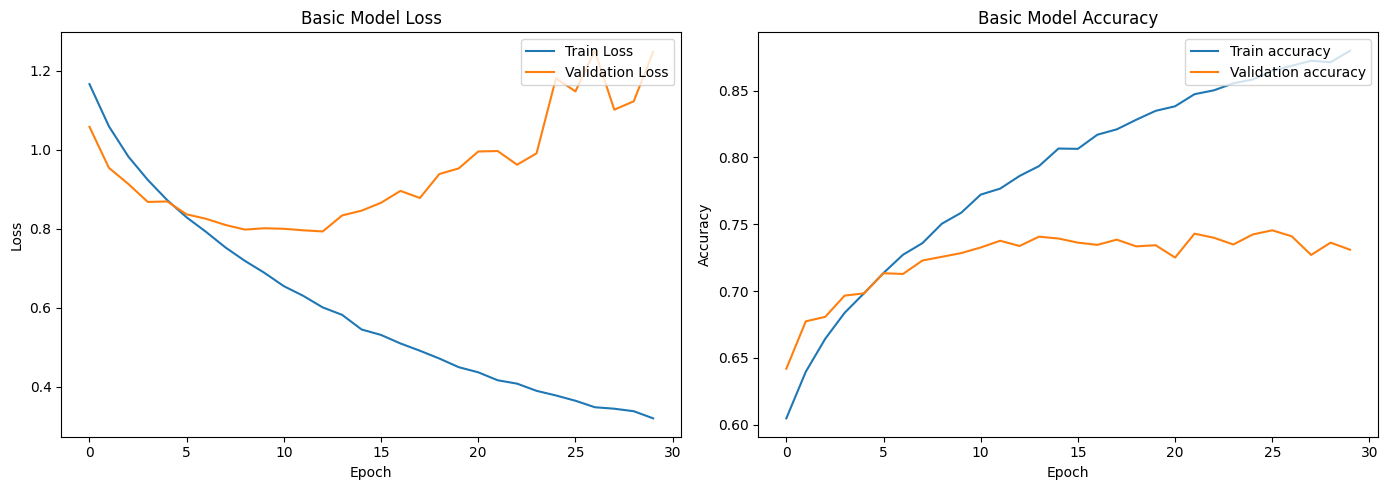

In [37]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(basic_model_history.history['loss'], label='Train Loss')
plt.plot(basic_model_history.history['val_loss'], label='Validation Loss')
plt.title('Basic Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(basic_model_history.history['accuracy'], label='Train accuracy')
plt.plot(basic_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Basic Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [40]:
# Get the prediction reusults
predictions = basic_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
test_labels, predicted_labels

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(array([7, 3, 0, ..., 4, 1, 3]), array([0, 2, 2, ..., 0, 0, 3], dtype=int64))

In [41]:
accuracy = accuracy_score(test_labels, predicted_labels)
print("Basic Model Accuracy:", accuracy)

Basic Model Accuracy: 0.71264689423615


## Confusion Matrix

Basic Model Confusion Matrix:
 [[981  63  39 134  38   3   4   0   0   0]
 [ 79 757  29  34  28   0   1   0   0   0]
 [ 34  20 355  15  14   0   6   0   0   0]
 [160  33   6 221  21   0   2   1   0   0]
 [ 55  33  18  21 197   1   0   0   0   0]
 [  4   4   2   2   5   6   0   0   0   0]
 [ 15   5  28  12   6   0  27   0   0   0]
 [ 12   2   3   7   1   0   0   2   0   0]
 [ 11   3   4   6   2   0   0   0   1   0]
 [  1   0   0   0   0   0   0   0   0   0]]


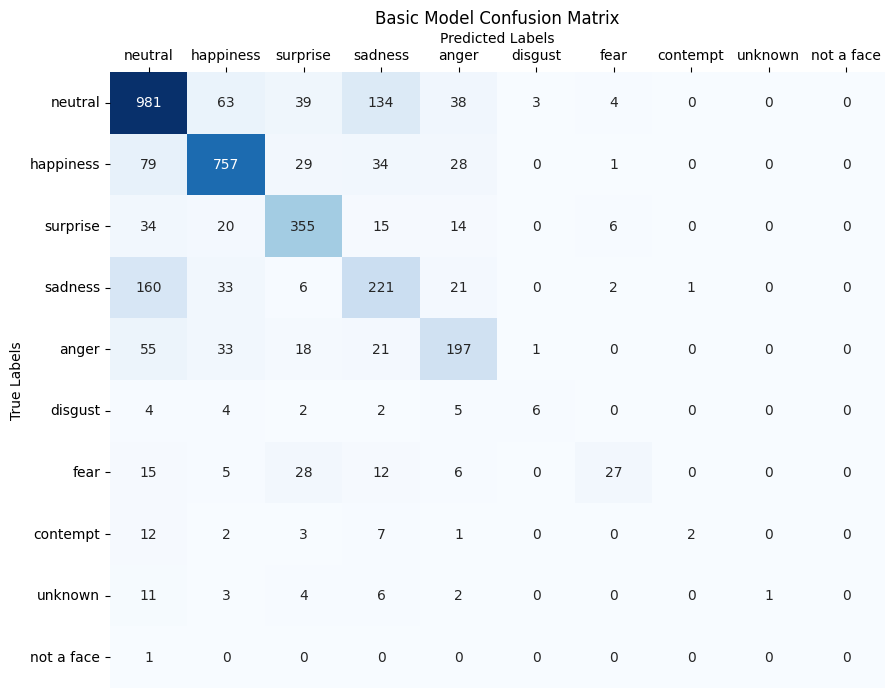

In [42]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
    5: "disgust",
    6: "fear",
    7: "contempt",
    8: "unknown",
    9: "not a face"
}

# Get the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Basic Model Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Basic Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()

# Balanced data

## Load

In [43]:
# Read data form csv
balanced_train_df = pd.read_csv("data/relevant_train_df.csv")
balanced_valid_df = pd.read_csv("data/relevant_valid_df.csv")
balanced_test_df = pd.read_csv("data/relevant_test_df.csv")
balanced_train_df.shape, balanced_valid_df.shape, balanced_test_df.shape

((16981, 3), (2121, 3), (2103, 3))

In [44]:
# Load and normalize images
def load_images(data, base_path):
    images = []
    labels = []
    paths = []
    
    # Mapping from Usage to directory names
    directory_map = {
        "Training": "FER2013Train",
        "PublicTest": "FER2013Valid",
        "PrivateTest": "FER2013Test"
    }
    
    for idx, row in data.iterrows():
        directory = directory_map.get(row['Usage'], None)
        if directory:
            image_path = os.path.join(base_path, directory, row['Image name'])
            
            if os.path.exists(image_path):
                # Load the image
                image = Image.open(image_path).convert('L')  # Convert to grayscale
                image_array = np.array(image) / 255.0  # Normalize to 0-1
                
                # Append data
                images.append(image_array)
                labels.append(row['predominant_emotion_index'])  # Select emotion intensity columns
                paths.append(image_path)
    
    return np.array(images), np.array(labels), paths

# Base path for images
base_image_path = 'FERPlus-master/data'

# Load images and their labels
balanced_train_images, balanced_train_labels, balanced_train_image_paths = load_images(balanced_train_df, base_image_path)
balanced_valid_images, balanced_valid_labels, balanced_valid_image_paths = load_images(balanced_valid_df, base_image_path)
balanced_test_images, balanced_test_labels, balanced_test_image_paths = load_images(balanced_test_df, base_image_path)

# Check shapes and an example path
print("Train images shape:", balanced_train_images.shape, balanced_train_images.dtype)
print("Train labels shape:", balanced_train_labels.shape, balanced_train_labels.dtype)

print("Valid images shape:", balanced_valid_images.shape, balanced_valid_images.dtype)
print("Valid labels shape:", balanced_valid_labels.shape, balanced_valid_labels.dtype)

print("Tests images shape:", balanced_test_images.shape, balanced_test_images.dtype)
print("Tests labels shape:", balanced_test_labels.shape, balanced_test_labels.dtype)


Train images shape: (16981, 48, 48) float64
Train labels shape: (16981,) int32
Valid images shape: (2121, 48, 48) float64
Valid labels shape: (2121,) int32
Tests images shape: (2103, 48, 48) float64
Tests labels shape: (2103,) int32


# Basic CNN

In [45]:
# Create a basic CNN model
balanced_basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),  # first conv layer
    MaxPooling2D((2, 2)),  # first pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # second conv layer
    MaxPooling2D((2, 2)),  # second pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # third conv layer
    MaxPooling2D((2, 2)),  # third pooling layer
    Flatten(),  # flatten the output for the dense layer
    Dense(128, activation='relu'),  # fully connected layer
    Dropout(0.5),  # dropout for regularization
    Dense(10, activation='softmax')  # output layer with 10 units for each emotion
])

balanced_basic_model.summary()  # This will print the summary of the model architecture

d:\Julio\Uc3m\TFG\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Compile the model
balanced_basic_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Reshape images to add channel dimension for CNN

In [47]:
# Reshape or modify the data to add a channel dimension for CNNs, expect an input shape like (batch, height, width, channels)
# Channel dimension is 1 for grayscale images
balanced_train_images = balanced_train_images.reshape((-1, 48, 48, 1))
balanced_valid_images = balanced_valid_images.reshape((-1, 48, 48, 1))
balanced_test_images = balanced_test_images.reshape((-1, 48, 48, 1))

In [48]:
print("Train images shape:", balanced_train_images.shape, balanced_train_images.dtype)
print("Train labels shape:", balanced_train_labels.shape, balanced_train_labels.dtype)

print("Valid images shape:", balanced_valid_images.shape, balanced_valid_images.dtype)
print("Valid labels shape:", balanced_valid_labels.shape, balanced_valid_labels.dtype)

print("Tests images shape:", balanced_test_images.shape, balanced_test_images.dtype)
print("Tests labels shape:", balanced_test_labels.shape, balanced_test_labels.dtype)

Train images shape: (16981, 48, 48, 1) float64
Train labels shape: (16981,) int32
Valid images shape: (2121, 48, 48, 1) float64
Valid labels shape: (2121,) int32
Tests images shape: (2103, 48, 48, 1) float64
Tests labels shape: (2103,) int32


## Fit model

In [49]:
# Fit the model
balanced_basic_model_history = balanced_basic_model.fit(
    balanced_train_images, balanced_train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(balanced_valid_images, balanced_valid_labels)
)

Epoch 1/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.2266 - loss: 1.7374 - val_accuracy: 0.3984 - val_loss: 1.4032
Epoch 2/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4104 - loss: 1.4143 - val_accuracy: 0.4903 - val_loss: 1.2303
Epoch 3/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4793 - loss: 1.2724 - val_accuracy: 0.5554 - val_loss: 1.1051
Epoch 4/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5508 - loss: 1.1342 - val_accuracy: 0.6082 - val_loss: 0.9864
Epoch 5/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5831 - loss: 1.0417 - val_accuracy: 0.6214 - val_loss: 0.9456
Epoch 6/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6212 - loss: 0.9698 - val_accuracy: 0.6403 - val_loss: 0.9047
Epoch 7/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6373 - loss: 0.9205 - val_accuracy: 0.6511 - val_loss: 0.8960
Epoch 8/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6537 - loss: 0.8828 - val_accu

## Save model

In [50]:
# Store the model to a .h5 file
balanced_basic_model.save('basic_model_balanced.keras')

## Load model

In [51]:
# Load the model from the .h5 file
#balanced_basic_model = load_model('basic_model_balanced.keras')

## Evaluate

In [52]:
# Evaluate the model
balanced_test_loss, balanced_test_acc = balanced_basic_model.evaluate(balanced_test_images, balanced_test_labels)
print("Basic Model Test Accuracy:", balanced_test_acc)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6822 - loss: 1.1085
Basic Model Test Accuracy: 0.6985259056091309


## Plot 

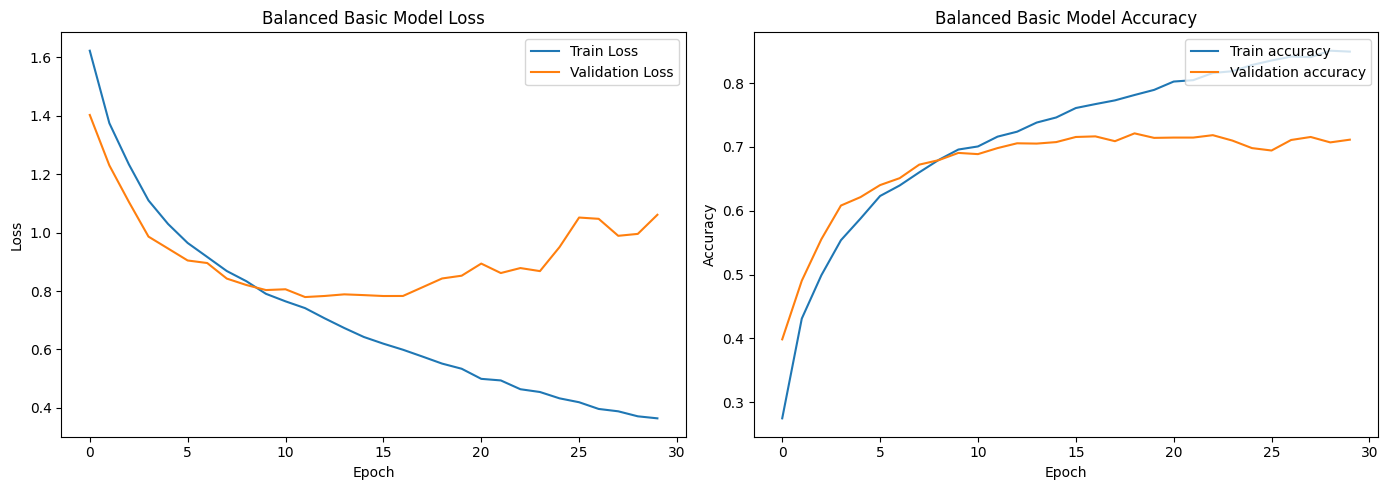

In [53]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(balanced_basic_model_history.history['loss'], label='Train Loss')
plt.plot(balanced_basic_model_history.history['val_loss'], label='Validation Loss')
plt.title('Balanced Basic Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(balanced_basic_model_history.history['accuracy'], label='Train accuracy')
plt.plot(balanced_basic_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Balanced Basic Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [54]:
# Get the prediction reusults
balanced_predictions = balanced_basic_model.predict(balanced_test_images)
balanced_predicted_labels = np.argmax(balanced_predictions, axis=1)
balanced_test_labels, balanced_predicted_labels

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(array([3, 2, 4, ..., 4, 1, 3]), array([0, 0, 4, ..., 0, 3, 3], dtype=int64))

In [55]:
balanced_accuracy = accuracy_score(balanced_test_labels, balanced_predicted_labels)
print("Basic Model Accuracy:", balanced_accuracy)

Basic Model Accuracy: 0.698525915359011


## Confusion Matrix

balanced Basic Model Confusion Matrix:
 [[314  25  19  73  31]
 [ 36 315  17  31  29]
 [ 40  14 354  15  21]
 [110  23  16 265  30]
 [ 47  13  17  27 221]]


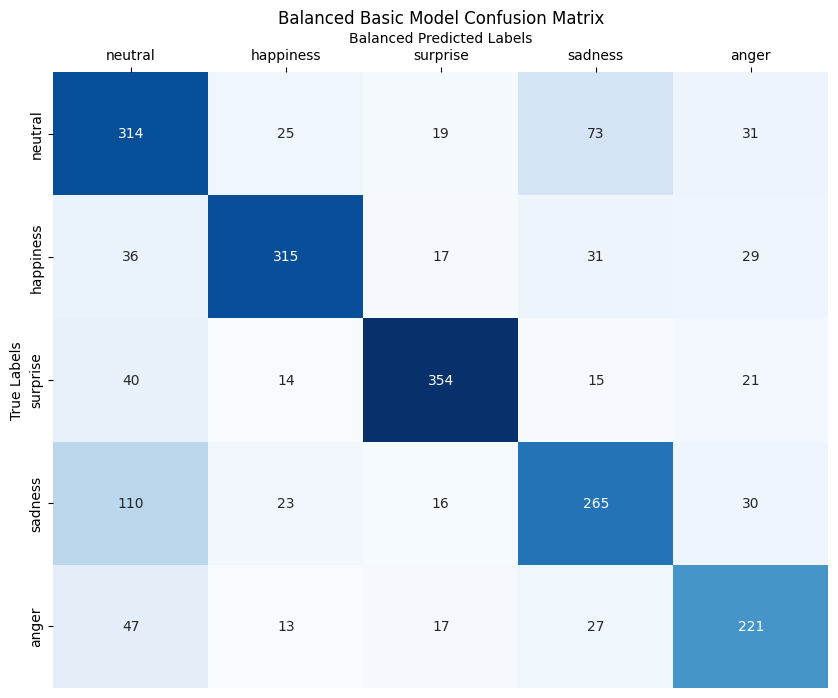

In [58]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
}

# Get the confusion matrix
balanced_conf_matrix = confusion_matrix(balanced_test_labels, balanced_predicted_labels)
print("balanced Basic Model Confusion Matrix:\n", balanced_conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(balanced_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Balanced Predicted Labels')
plt.ylabel('True Labels')
plt.title('Balanced Basic Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()